In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
import warnings 
warnings.filterwarnings("ignore")

# Reflect Tables into SQLAlchemy ORM

In [3]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
# Base.prepare(engine, reflect=True) - Other option
Base.prepare(autoload_with=engine)

In [5]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Get the table names using `inspect()`.
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
# Get a list of column names and types from measurement
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
# Get a list of column names and types from station
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
#fetchall to look at data in measurement table
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [12]:
#number of measurements in measurement table
count_measurement_dates = session.query(measurement).group_by(measurement.date).count()
print(f'Measurements are taken over: {count_measurement_dates} days')

Measurements are taken over: 2792 days


In [13]:
first_measurement_date = session.query(measurement.date).order_by(measurement.date).first()
first_measurement_date = first_measurement_date[0]
print(f'First measurement of precipitation was taken on: {first_measurement_date}')

First measurement of precipitation was taken on: 2010-01-01


In [14]:
# Find the most recent date in the measurement table
most_recent_date = session.query(func.max(measurement.date)).scalar()
print(f"The most recent measurement of precipitation was taken in the dataset on: {most_recent_date}")

The most recent measurement of precipitation was taken in the dataset on: 2017-08-23


In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(func.max(measurement.date)).scalar()

# Calculate the date one year from the most recent date
one_year_ago = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=366)
print(f"One year ago from the most recent date: {one_year_ago.strftime('%Y-%m-%d')}")

One year ago from the most recent date: 2016-08-22


In [16]:
# Perform a query to retrieve the data and precipitation scores
# Query to retrieve the last 12 months of precipitation data
precipitation_data = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= one_year_ago).\
    order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])

# Sort the DataFrame by date
precipitation_df['date'] = pd.to_datetime(precipitation_df['date'])
precipitation_df = precipitation_df.sort_values('date')
precipitation_df.head()

,date,precipitation
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02


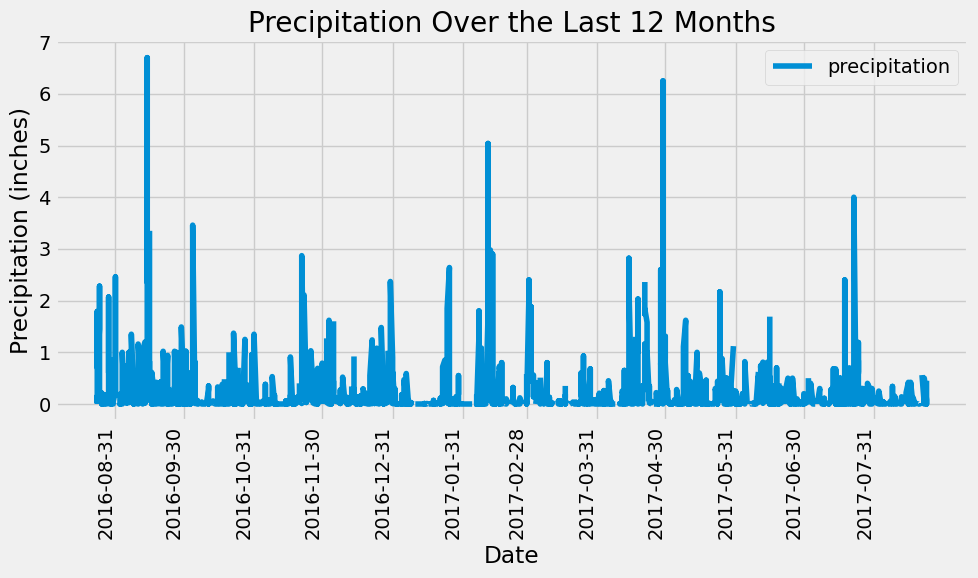

In [17]:
# Create a date range with a one-month frequency
date_range = pd.date_range(start=precipitation_df['date'].min(), end=precipitation_df['date'].max(), freq='M')

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x='date', y='precipitation', kind='line', figsize=(10, 6), title='Precipitation Over the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')

# Set x-ticks with a one-month gap
plt.xticks(date_range, rotation=90)

plt.tight_layout()
plt.show()

In [18]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = precipitation_df['precipitation'].describe()
summary_statistics

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [19]:
# Design a query to calculate the total number of stations in the dataset
num_stations = session.query(station).distinct().count()
print(f'Number of stations in the measurement table are: {num_stations}')

Number of stations in the measurement table are: 9


In [20]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# Query to find the most active stations
stations_activity = session.query(measurement.station,func.count(measurement.station)\
                    .label('count'))\
                    .group_by(measurement.station)\
                    .order_by(func.count(measurement.station)\
                    .desc()).all()

# Print the results
for station, count in stations_activity:
    print(f'Station: {station}, Count: {count}')

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [21]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Most active station ID
most_active_station = 'USC00519281'

# Query to calculate the lowest, highest, and average temperature
temperature_stats = session.query(
    func.min(measurement.tobs).label('min_temp'),
    func.max(measurement.tobs).label('max_temp'),
    func.avg(measurement.tobs).label('avg_temp')
).filter(measurement.station == most_active_station).all()

# Extract the results
min_temp, max_temp, avg_temp = temperature_stats[0]

print(f'Lowest Temperature: {min_temp}')
print(f'Highest Temperature: {max_temp}')
print(f'Average Temperature: {avg_temp:.2f}')


Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66


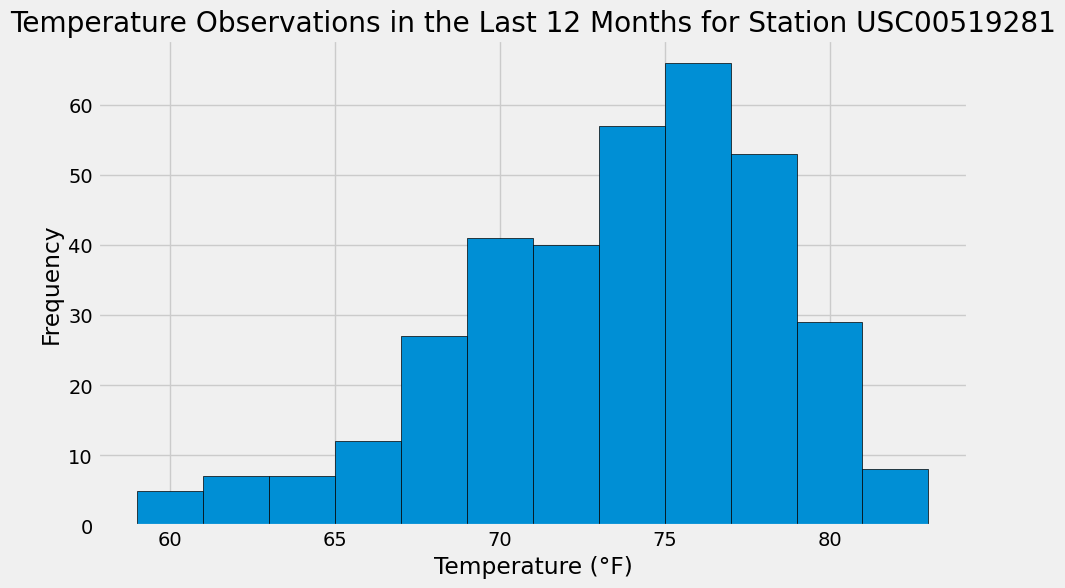

In [22]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Query the temperature observation data for the last 12 months
temperature_data = session.query(measurement.date, measurement.tobs).filter(
    measurement.station == most_active_station,
    measurement.date >= one_year_ago
).all()

# Convert the query results to a DataFrame
df = pd.DataFrame(temperature_data, columns=['date', 'tobs'])

# Plot the temperature data as a histogram
plt.figure(figsize=(10, 6))
plt.hist(df['tobs'], bins=12, edgecolor='black')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Temperature Observations in the Last 12 Months for Station USC00519281')
plt.show()


# Close Session

In [23]:
# Close Session
session.close()